In [1]:
from deepCNN import deepCNN
from utils import *
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [3]:
model = deepCNN().to(device)
print(model)

deepCNN(
  (ConvLayer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 10), stride=(1, 1))
    (1): ELU(alpha=0.9, inplace=True)
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.15, affine=True, track_running_stats=True)
    (3): Conv2d(25, 25, kernel_size=(22, 1), stride=(1, 1))
    (4): ELU(alpha=0.9, inplace=True)
    (5): BatchNorm2d(25, eps=1e-05, momentum=0.15, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.15, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 10), stride=(1, 1))
    (1): ELU(alpha=0.9, inplace=True)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.15, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.15, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 10), stride=(1, 1))
   

In [4]:
X_train, y_train, X_test, y_test = init_data(subject=None)
train_loader, val_loader, test_loader = load_data(X_train, y_train, X_test, y_test, verbose=True)

print(train_loader)

In [5]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-8, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 40

for epoch_idx in range(num_epochs):
    model.train() 
    train_count = 0
    train_correct_count = 0
    train_loss_accum = 0.0 
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad()
        logits = model(train_x)
        train_loss = criterion(logits, train_y)
        train_loss.backward()
        optimizer.step()
        train_loss_accum += train_loss.item() * train_x.size(0)
        
        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)
            
    train_acc = train_correct_count / train_count
    avg_train_loss = train_loss_accum / train_count
    
    model.eval()
    val_count = 0
    val_correct_count = 0
    val_loss_accum = 0.0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            val_loss = criterion(logits, val_y) 
            val_loss_accum += val_loss.item() * val_x.size(0)
            
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
            
    val_acc = val_correct_count / val_count
    avg_val_loss = val_loss_accum / val_count

    scheduler.step()
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc.detach().cpu().item())
    val_accuracies.append(val_acc.detach().cpu().item())
    
    print('>>>Epoch: {:d}   Train Loss: {:.3f}, Train Acc: {:.3f}, Val Loss: {:.3f}, Val Acc: {:.3f}'.format(
        epoch_idx+1, avg_train_loss, train_acc, avg_val_loss, val_acc))

>>>Epoch: 1   Train Loss: 1.362, Train Acc: 0.334, Val Loss: 1.274, Val Acc: 0.444
>>>Epoch: 2   Train Loss: 1.275, Train Acc: 0.437, Val Loss: 1.243, Val Acc: 0.478
>>>Epoch: 3   Train Loss: 1.217, Train Acc: 0.517, Val Loss: 1.217, Val Acc: 0.504
>>>Epoch: 4   Train Loss: 1.182, Train Acc: 0.565, Val Loss: 1.185, Val Acc: 0.546
>>>Epoch: 5   Train Loss: 1.144, Train Acc: 0.618, Val Loss: 1.162, Val Acc: 0.591
>>>Epoch: 6   Train Loss: 1.110, Train Acc: 0.651, Val Loss: 1.153, Val Acc: 0.603
>>>Epoch: 7   Train Loss: 1.074, Train Acc: 0.700, Val Loss: 1.155, Val Acc: 0.582
>>>Epoch: 8   Train Loss: 1.029, Train Acc: 0.757, Val Loss: 1.170, Val Acc: 0.586
>>>Epoch: 9   Train Loss: 0.964, Train Acc: 0.839, Val Loss: 1.140, Val Acc: 0.624
>>>Epoch: 10   Train Loss: 0.948, Train Acc: 0.853, Val Loss: 1.137, Val Acc: 0.619
>>>Epoch: 11   Train Loss: 0.938, Train Acc: 0.871, Val Loss: 1.138, Val Acc: 0.612
>>>Epoch: 12   Train Loss: 0.930, Train Acc: 0.871, Val Loss: 1.137, Val Acc: 0.612
>

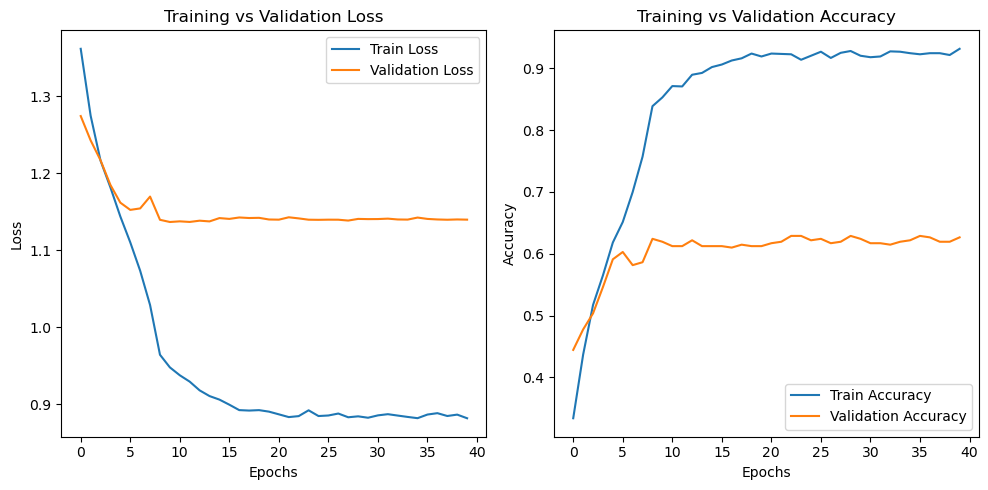

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 45.372460496613996%
